In [23]:
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # Support Vector Classifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


In [133]:
#### Helper functions


def gc_content(sequence):
    """
    Compute the GC content of a DNA sequence.

    Parameters:
        sequence (str): DNA sequence (e.g., "ATGCATGC").
    
    Returns:
        float: Fraction of G and C bases in the sequence.
    """
    return (sequence.count('G') + sequence.count('C')) / len(sequence)


def melting_temp(primer_sequence):
    """
    Calculate the melting temperature (Tm) of a DNA primer using:
    1. Wallace Rule
    2. Salt-adjusted formula for longer primers (>14 bases)

    Parameters:
        primer_sequence (str): DNA primer sequence (e.g., "ATGCATGCATGC")

    Returns:
        dict: Tm values for Wallace Rule and Salt Adjusted formulas
    """
    primer_sequence = primer_sequence.upper()
    A_count = primer_sequence.count("A")
    T_count = primer_sequence.count("T")
    G_count = primer_sequence.count("G")
    C_count = primer_sequence.count("C")
    primer_length = len(primer_sequence)

    # Salt-adjusted Tm for primers > 14 bases
    if primer_length > 14:
        tm = 64.9 + 41 * (G_count + C_count - 16.4) / primer_length
    else: 
    # Wallace Rule Tm
        tm = 2 * (A_count + T_count) + 4 * (G_count + C_count)


    return tm

def self_folding_mfe(sequence, is_dna=True):
    """
    Calculate the minimum free energy (MFE) of a DNA or RNA sequence.

    Parameters:
        sequence (str): The DNA or RNA sequence.
        is_dna (bool): Whether the sequence is DNA (default: True).
    
    Returns:
        float: Minimum free energy (MFE).
        str: Folded structure.
    """
    # Convert DNA to RNA (if applicable)
    if is_dna:
        sequence = sequence.replace("T", "U")
    
    # Run RNAfold via subprocess
    process = subprocess.Popen(
        ["RNAfold"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate(input=f"{sequence}\n".encode())

    # Parse output
    output = stdout.decode().strip().split("\n")
    folded_structure = output[1].split(" ")[0]  # The dot-bracket notation
    mfe = float(output[1].split(" ")[-1].strip("()"))  # The MFE value

    return mfe

# Helper function: Extreme GC content in regions
def extreme_gc(sequence, start, end):
    """
    Identify if a specified region of the DNA sequence has extreme GC content.

    Parameters:
        sequence (str): DNA sequence (e.g., "ATGCATGC").
        start (int): Start position of the region (0-based indexing).
        end (int): End position of the region (exclusive).

    Returns:
        int: 1 if GC content is < 0.3 or > 0.7, otherwise 0.
    """
    region = sequence[start:end]
    gc_percentage = gc_content(region)
    return 1 if gc_percentage < 0.3 or gc_percentage > 0.7 else 0


# Helper function to check presence of specific motifs
def contains_motif(sequence, motif):
    """
    Check if a specific motif is present in the DNA sequence.

    Parameters:
        sequence (str): DNA sequence (e.g., "ATGCATGC").
        motif (str): Motif to check for (e.g., "GGGG").
    
    Returns:
        int: 1 if the motif is present, otherwise 0.
    """
    return 1 if motif in sequence else 0


# Feature engineering
def engineer_aggregate_features(df):    
    """
    Engineer aggregate features for DNA sequences in a DataFrame.

    Features include GC content, melting temperature, self-folding minimum
    free energy, presence of motifs, position-specific nucleotide properties,
    and nucleotide counts.

    Parameters:
        df (pd.DataFrame): DataFrame with a column 'Spacer' containing DNA sequences.
    
    Returns:
        pd.DataFrame: DataFrame with additional engineered features.
    """
    # Vectorize utility functions
    gc_content_vec = np.vectorize(gc_content)
    melting_temp_vec = np.vectorize(melting_temp)
    extreme_gc_vec = np.vectorize(extreme_gc)
    self_folding_mfe_vec = np.vectorize(self_folding_mfe)
    contains_motif_vec = np.vectorize(contains_motif)

    # Compute GC content
    #df['GC_content'] = gc_content_vec(df['Spacer'])
    df['GC_content_p1_10'] = gc_content_vec(df['Spacer'].str[:10])

    # Compute melting temperature
    df['melting_temp'] = melting_temp_vec(df['Spacer'])

    # Compute extreme GC content in specific regions
    #df['extreme_gc_2_3'] = extreme_gc_vec(df['Spacer'], 1, 3)
    #df['extreme_gc_8'] = extreme_gc_vec(df['Spacer'], 7, 8)

    # Compute self-folding minimum free energy
    df['self_folding_mfe'] = self_folding_mfe_vec(df['Spacer'])

    # Check for presence of specific motifs
    motifs = ['GGGG', 'TTTT', 'AAAA', 'CCCC', 'GG', 'TT']
    for motif in motifs:
        df[f'contains_{motif}'] = contains_motif_vec(df['Spacer'], motif)

    # Generate combinations of purines and other motifs
    purines = [''.join(comb) for comb in product('AG', repeat=4)]
    pos1_2_motifs = ['AA', 'TC', 'CC']
    pos19_20_motifs_neg = ['AC', 'AG', 'CA', 'CC', 'GG']
    pos19_20_motifs_pos = ['TA', 'CT', 'GC']

    # Vectorized position-specific properties
    df['purines_p17-20'] = np.vectorize(lambda x: 1 if x[-4:] in purines else 0)(df['Spacer'])
    df['TTT_in_seed'] = contains_motif_vec(df['Spacer'].str[-13:], 'TTT')
    df['pos1_2_motifs'] = np.vectorize(lambda x: 1 if x[0:2] in pos1_2_motifs else 0)(df['Spacer'])
    df['pos19_20_motifs_neg'] = np.vectorize(lambda x: 1 if x[-2:] in pos19_20_motifs_neg else 0)(df['Spacer'])
    df['pos19_20_motifs_pos'] =  np.vectorize(lambda x: 1 if x[-2:] in pos19_20_motifs_pos else 0)(df['Spacer'])

    # Frequency of individual nucleotides
    for nucleotide in ['A', 'T', 'G', 'C']:
        df[f'{nucleotide}_count'] = np.vectorize(lambda x: x.count(nucleotide))(df['Spacer'])

    return df


In [135]:
# Read data

full_data = pd.read_excel('./data/full_LFC_data.xlsx')
sequence_data = pd.read_excel('./data/combined_with_nontargets.xlsx')

# Merge tables

df = pd.merge(full_data, sequence_data, how='left', left_on='ID', right_on='ID')

# delete non target gRNAs
df = df[~df['ID'].str.startswith('nt-gRNA')]

In [136]:
# Feature engineering

# Initalize scalers
min_max_scaler = MinMaxScaler() # initialize min_max for TSS
standard_scaler = StandardScaler() # initialize standard for all other features

# Apply all functions
df = engineer_aggregate_features(df)

# Get dummies for categorical
df = pd.get_dummies(df, columns=['Strand', 'target'], drop_first=True)

# scale TSS
df['Pos_from_start'] = min_max_scaler.fit_transform(df[['TSS_dist']])

# Add a new column for the strongest effect
effect_columns = ['37W_LFC', '37R_LFC', '37B_LFC', '22W_LFC', '22R_LFC', '22B_LFC', '37di_LFC']
df['gRNA strength'] = df[effect_columns].apply(lambda row: row.iloc[np.argmax(np.abs(row))], axis=1)

# drop unwanted columns
df.drop(['37W_LFC', '37R_LFC', '37B_LFC', '22W_LFC', '22R_LFC', '22B_LFC',
       '37di_LFC','Unnamed: 0', 'ID', 'locus', 'gene', 'product', 'note',
       'Component', 'NGG_dupe_count', 'PAM_index', 'PAM_type',
      'dupe_loci', 'duplicates', 'index', 'locus_tag',
       'rank_score', 'score', 'subpool', 'Spacer', 'TSS_dist'], axis=1, inplace=True)

df.to_csv('./data/temp_df.csv')
print("DataFrame saved to 'output.csv'")

DataFrame saved to 'output.csv'


In [125]:
df = pd.read_csv('./data/temp_df.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

df = df[(df['gRNA strength'] < -2) | (df['gRNA strength'] > 2)]

#Define bins and labels
# bins = [-np.inf, -3, -0.4, 0.4, 3, np.inf]
# labels = ['-Strong Effect', '-Medium Effect', 'No Effect', 'Medium Effect', 'Strong Effect']

#Define bins and labels
bins = [2, 4, np.inf]
labels = [2, 4]

# Bin gRNA strength
df['gRNA strength'] = pd.cut(df['gRNA strength'].abs(), bins=bins, labels=labels)


In [126]:
df['gRNA strength'].value_counts()

gRNA strength
4    4116
2    3295
Name: count, dtype: int64

In [127]:
# sns.countplot(data=df, x='gRNA strength', hue='gRNA strength')

In [128]:
# Prep data for training

X = df.drop('gRNA strength', axis=1)
y = df['gRNA strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)


# Testing smote_tomek to balance classes

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)


model = CatBoostClassifier(
    iterations=3000,                  # More iterations for harder tasks
    learning_rate=0.03,               # Lower learning rate for stability
    depth=10,                         # Larger depth for complex patterns
    l2_leaf_reg=5,                    # Regularization to reduce overfitting          
    loss_function='Logloss',          # Binary classification
    eval_metric='AUC',                # Use AUC for imbalanced tasks
    bootstrap_type='Bayesian',        # Improved bootstrapping                
    colsample_bylevel=0.8,            # Use 80% of features per tree level               
    verbose=100                       # Log progress every 100 iterations
)

exclude_col = ['Pos_from_start']
scaler = StandardScaler()

# Scale training data
columns_to_scale = X_train_resampled.columns.difference(exclude_col)
temp_scaled_X_train = scaler.fit_transform(X_train_resampled[columns_to_scale])
temp_scaled_X_train_df = pd.DataFrame(temp_scaled_X_train, columns=columns_to_scale, index=X_train_resampled.index)
scaled_X_train = pd.concat([X_train_resampled[exclude_col], temp_scaled_X_train_df], axis=1)

# Scale test data
temp_scaled_X_test = scaler.transform(X_test[columns_to_scale])
temp_scaled_X_test_df = pd.DataFrame(temp_scaled_X_test, columns=columns_to_scale, index=X_test.index)
scaled_X_test = pd.concat([X_test[exclude_col], temp_scaled_X_test_df], axis=1)

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(scaled_X_test)
accuracy_score(y_test, y_pred)



0:	total: 7.25ms	remaining: 21.8s
100:	total: 985ms	remaining: 28.3s
200:	total: 1.78s	remaining: 24.9s
300:	total: 2.58s	remaining: 23.1s
400:	total: 3.37s	remaining: 21.8s
500:	total: 4.13s	remaining: 20.6s
600:	total: 4.9s	remaining: 19.6s
700:	total: 5.67s	remaining: 18.6s
800:	total: 6.44s	remaining: 17.7s
900:	total: 7.2s	remaining: 16.8s
1000:	total: 7.95s	remaining: 15.9s
1100:	total: 8.72s	remaining: 15s
1200:	total: 9.51s	remaining: 14.2s
1300:	total: 10.3s	remaining: 13.4s
1400:	total: 11s	remaining: 12.5s
1500:	total: 11.6s	remaining: 11.6s
1600:	total: 12.3s	remaining: 10.8s
1700:	total: 13s	remaining: 9.91s
1800:	total: 13.7s	remaining: 9.09s
1900:	total: 14.3s	remaining: 8.29s
2000:	total: 15s	remaining: 7.5s
2100:	total: 15.7s	remaining: 6.71s
2200:	total: 16.4s	remaining: 5.94s
2300:	total: 17s	remaining: 5.18s
2400:	total: 17.7s	remaining: 4.42s
2500:	total: 18.4s	remaining: 3.67s
2600:	total: 19.1s	remaining: 2.93s
2700:	total: 19.8s	remaining: 2.19s
2800:	total: 20.

0.476062036412677

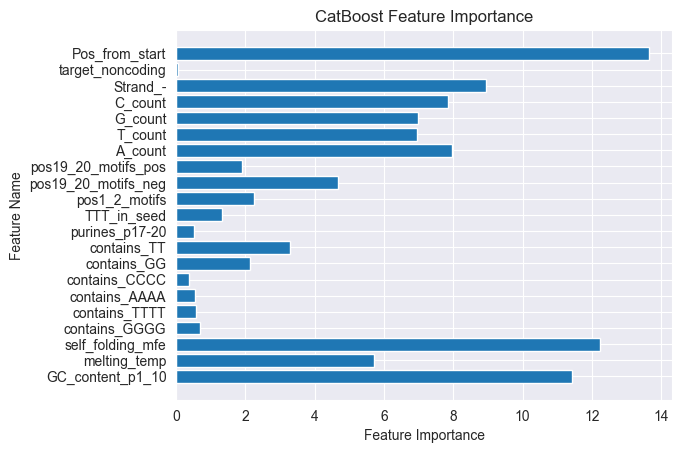

In [129]:
# Plot feature importance
feature_importance = model.get_feature_importance()
features = X_train.columns

plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('CatBoost Feature Importance')
plt.show()

In [130]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.44      0.68      0.53       650
           4       0.56      0.31      0.40       833

    accuracy                           0.48      1483
   macro avg       0.50      0.50      0.47      1483
weighted avg       0.51      0.48      0.46      1483



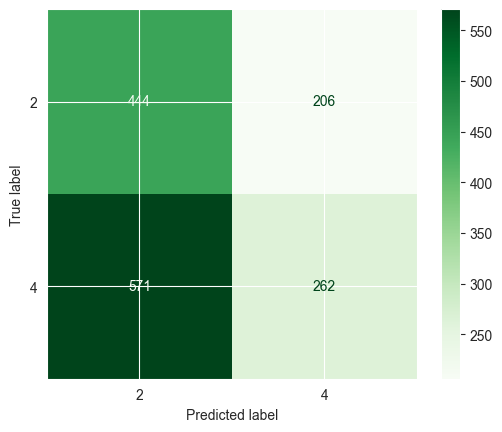

In [131]:

matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(matrix, display_labels=np.unique(y)) 
print(cm_display)
cm_display.plot(cmap = 'Greens')